In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scikit-plot

In [3]:
import math
import numpy as np
import pandas as pd
import scikitplot as skplt
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

In [4]:
data = pd.read_csv('/content/drive/MyDrive/fer/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
data.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [6]:
emotion_labels = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [7]:
data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

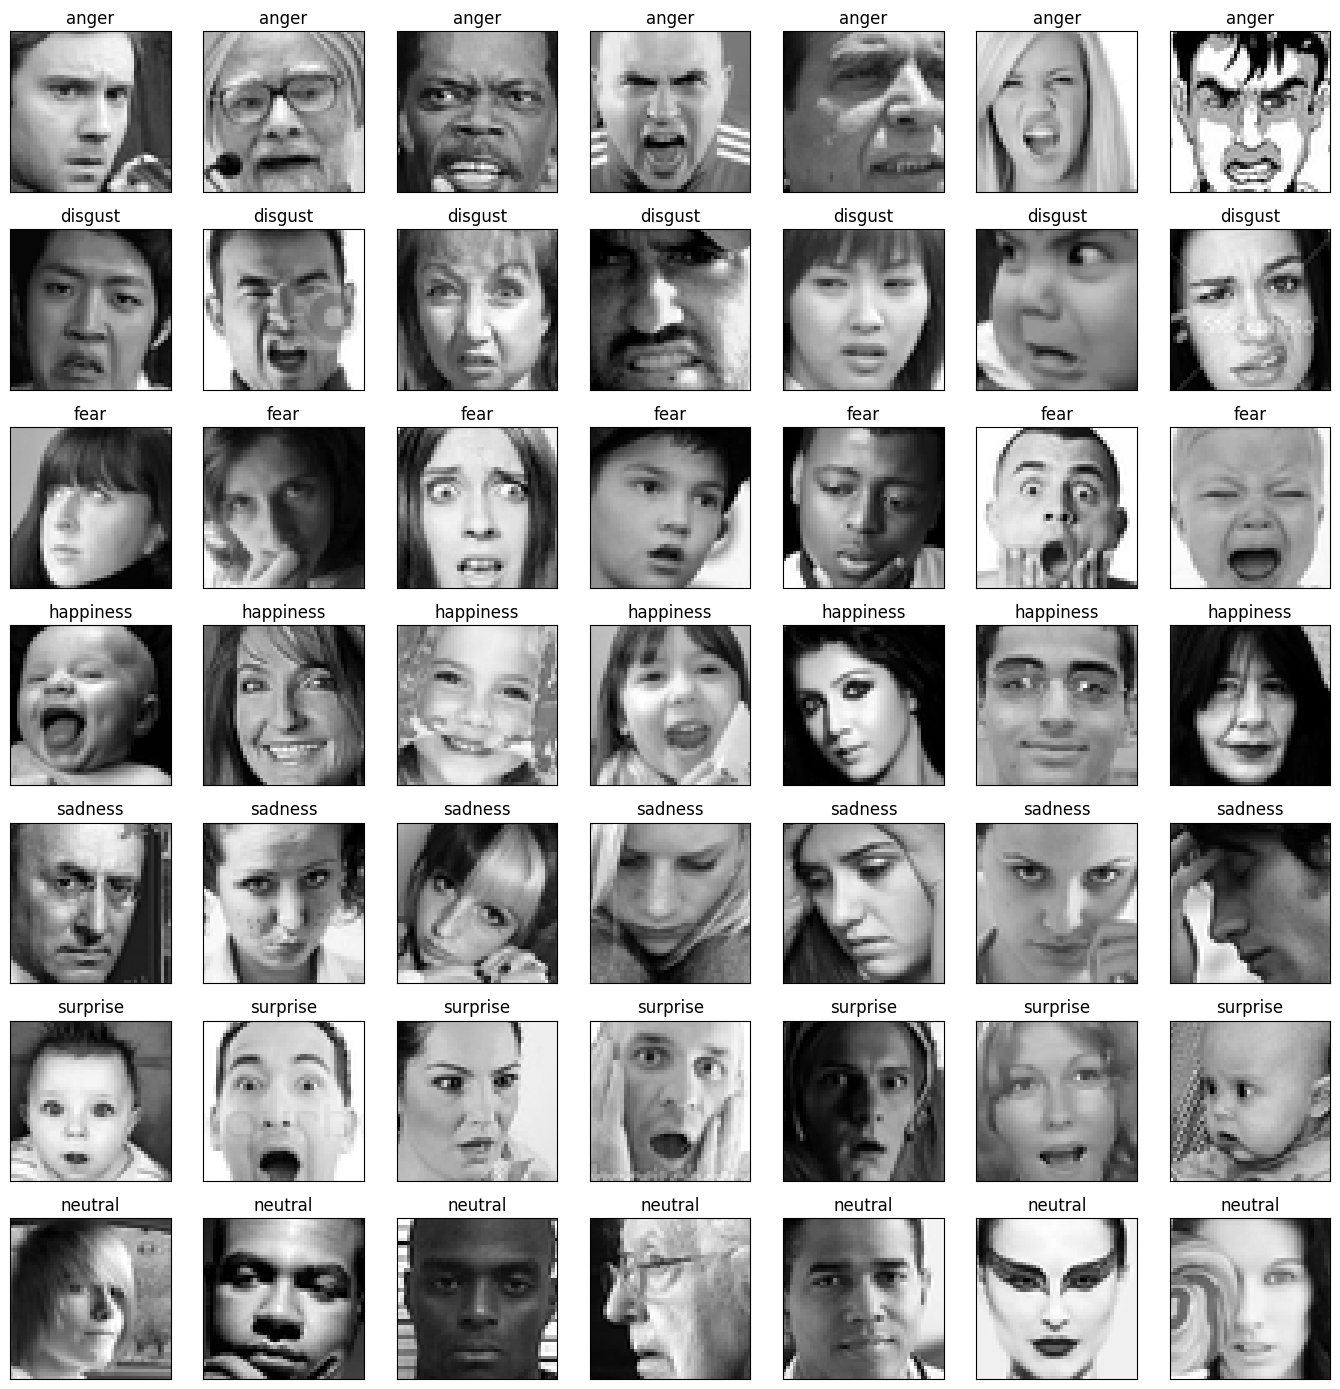

In [8]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(data.emotion.unique()):
    for j in range(7):
        px = data[data.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_labels[label])
        pyplot.tight_layout()

In [9]:
# discarding emotions Disgust & fear
used_labels=[3,6,4,0,5]

In [10]:
# discarding emotions Disgust & Suprise to get slightly balanced dataset
used_labels=[3,6,4,2,0]

In [11]:
# Using full original dataset
used_labels=[3,6,4,2,0,5,1]

In [12]:
data = data[data.emotion.isin(used_labels)]
data.shape

(35887, 3)

In [13]:
img_array = data.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [14]:
img_array.shape

(35887, 48, 48, 1)

In [15]:
from sklearn.preprocessing import OneHotEncoder
LE= LabelEncoder()
image_labels = LE.fit_transform(data.emotion)
image_labels = np_utils.to_categorical(image_labels)
image_labels[5]


array([0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [16]:
LE.classes_

array([0, 1, 2, 3, 4, 5, 6])

In [17]:
LE_name_mapping = dict(zip(LE.classes_, LE.transform(LE.classes_)))
print(LE_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(img_array, image_labels, test_size=0.1, shuffle=True, stratify=image_labels,random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

In [19]:
X_valid.shape

(3230, 48, 48, 1)

In [20]:
X_train.shape

(29068, 48, 48, 1)

In [21]:
X_test.shape

(3589, 48, 48, 1)

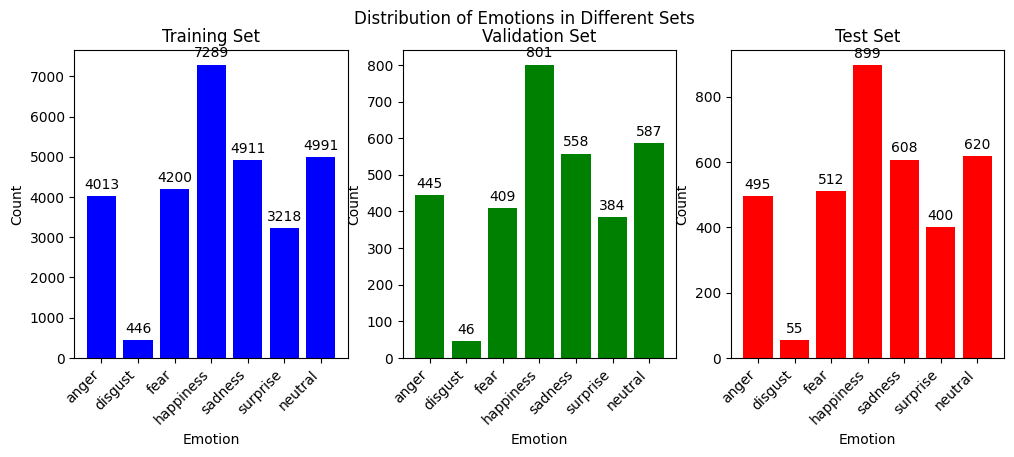

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Define the class labels
class_labels =emotion_labels


# Define the colors to use for each set
set_colors = ['blue', 'green', 'red']

# Define the sets of labels to plot
label_sets = [y_train, y_valid, y_test]
set_names = ['Training Set', 'Validation Set', 'Test Set']

# Get the counts for each set and class
counts = [np.sum(labels, axis=0) for labels in label_sets]

# Create the subplot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

# Loop over the sets and plot the histograms
for i, ax in enumerate(axs.flat):
    # Create the histogram plot
    bars = ax.bar(class_labels.values(), counts[i], color=set_colors[i])

    # Set the x-axis tick labels to be tilted by 45 degrees
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Add the count number on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.0f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    ax.set_xlabel('Emotion')
    ax.set_ylabel('Count')
    ax.set_title(set_names[i])

# Set the overall title of the plot
fig.suptitle('Distribution of Emotions in Different Sets')

# # Set the background color of the subplots to white
# plt.rcParams['axes.facecolor'] = 'white'

# # Adjust the spacing between the subplots
# plt.subplots_adjust(wspace=0.3)

# Show the plot
plt.show()


In [23]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [24]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.
X_test = X_test/255.


In [25]:
def build_net(optim):
    img_input = Input(shape=(img_width, img_height, img_depth))

    Conv1 = Conv2D(filters=64, kernel_size=(5,5), activation='elu', padding='same',
               kernel_initializer='he_normal')(img_input)
    B1 = BatchNormalization()(Conv1)
    Conv2 = Conv2D(filters=64, kernel_size=(5,5), activation='elu', padding='same',
               kernel_initializer='he_normal')(B1)
    B2 = BatchNormalization()(Conv2)
    M1 = MaxPooling2D(pool_size=(2,2))(B2)
    D1 = Dropout(0.4)(M1)

    Conv3 = Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same',
               kernel_initializer='he_normal')(D1)
    B3 = BatchNormalization()(Conv3)
    Conv4 = Conv2D(filters=128, kernel_size=(3,3), activation='elu', padding='same',
               kernel_initializer='he_normal')(B3)
    B4 = BatchNormalization()(Conv4)
    M2 = MaxPooling2D(pool_size=(2,2))(B4)
    D2 = Dropout(0.4)(M2)

    Conv5 = Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same',
               kernel_initializer='he_normal')(D2)
    B5 = BatchNormalization()(Conv5)
    Conv6 = Conv2D(filters=256, kernel_size=(3,3), activation='elu', padding='same',
               kernel_initializer='he_normal')(B5)
    B6 = BatchNormalization()(Conv6)
    M3 = MaxPooling2D(pool_size=(2,2))(B6)
    D3 = Dropout(0.5)(M3)

    x = Flatten()(D3)
    DN1 = Dense(128, activation='elu', kernel_initializer='he_normal')(x)
    B7 = BatchNormalization()(DN1)
    D4 = Dropout(0.6)(B7)

    output = Dense(num_classes, activation='softmax')(D4)

    net = Model(img_input, output)

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()
    return net

In [26]:
"""
Using two callbacks  , one is `early stopping` for avoiding overfitting training data
and another is  `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [27]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

### Plotting Train Test and Validation Sets

In [28]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]


model = build_net(optims[1])
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0     

<ipython-input-28-b2bfb347fe44>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


908/908 [==============================] - 47s 35ms/step - loss: 2.0072 - accuracy: 0.2381 - val_loss: 1.6546 - val_accuracy: 0.3384 - lr: 0.0010
Epoch 2/100
908/908 [==============================] - 31s 34ms/step - loss: 1.6568 - accuracy: 0.3401 - val_loss: 1.4125 - val_accuracy: 0.4464 - lr: 0.0010
Epoch 3/100
908/908 [==============================] - 31s 34ms/step - loss: 1.4953 - accuracy: 0.4232 - val_loss: 1.3021 - val_accuracy: 0.5115 - lr: 0.0010
Epoch 4/100
908/908 [==============================] - 31s 34ms/step - loss: 1.4005 - accuracy: 0.4641 - val_loss: 1.2637 - val_accuracy: 0.5102 - lr: 0.0010
Epoch 5/100
908/908 [==============================] - 33s 36ms/step - loss: 1.3500 - accuracy: 0.4826 - val_loss: 1.1874 - val_accuracy: 0.5430 - lr: 0.0010
Epoch 6/100
908/908 [==============================] - 30s 33ms/step - loss: 1.2978 - accuracy: 0.5110 - val_loss: 1.2374 - val_accuracy: 0.5372 - lr: 0.0010
Epoch 7/100
908/908 [==============================] - 30s 33ms/

### Without Augmentation

In [29]:
# batch_size = 32 #batch size of 32 performs the best.
# epochs = 100
# optims = [
#     optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
#     optimizers.Adam(0.001),
# ]

# model = build_net(optims[1])
# #train without augmentation
# history= model.fit(np.array(X_train), np.array(y_train),
#           batch_size=32,
#           steps_per_epoch=len(X_train) / batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(np.array(X_valid), np.array(y_valid)),
#           shuffle=True,
#           callbacks=callbacks)

In [30]:
model_70 = model.to_json()
with open("model.70", "w") as json_file:
    json_file.write(model_70)

model.save("model.h5")

### Evaluation On the Best Model

In [31]:
loaded_model = tf.keras.models.load_model('/content/model.h5')

In [32]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 64)        1664      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0     

In [33]:
predict_x = loaded_model.predict(X_test)
classes_x = np.argmax(predict_x,axis= 1)

113/113 [==============================] - 1s 9ms/step


In [34]:
true_class = np.argmax(y_test,axis=1)

In [35]:
true_class.shape

(3589,)

In [36]:
classes_x.shape, X_test.shape, y_test.shape

((3589,), (3589, 48, 48, 1), (3589, 7))

## Plotting Missclassified Samples

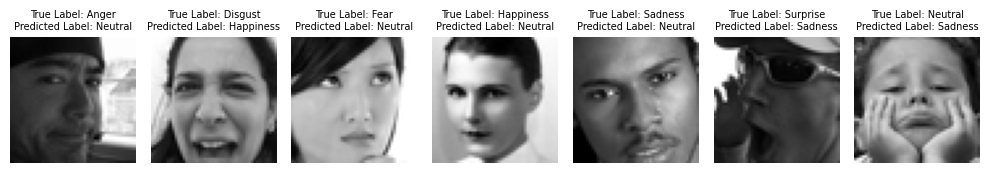

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Define the emotion labels
emotion_labels = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sadness', 5: 'Surprise', 6: 'Neutral'}

# Find misclassified images for each emotion category
misclassified_images = []
for emotion_label in emotion_labels.values():
    # Get indices of misclassified images for the current emotion label
    misclassified_indices = np.where((classes_x != true_class) & (true_class == list(emotion_labels.keys())[list(emotion_labels.values()).index(emotion_label)]))[0]
    if len(misclassified_indices) > 0:
        # Randomly select a misclassified image for the current emotion label
        random_index = np.random.choice(misclassified_indices)
        misclassified_images.append((X_test[random_index], true_class[random_index], classes_x[random_index]))

# Display the misclassified images
fig, axs = plt.subplots(ncols=len(misclassified_images), figsize=(10, 5))

for i, (image, true_label, predicted_label) in enumerate(misclassified_images):
    # Reshape the image from (48, 48, 1) to (48, 48)
    image = image.squeeze()

    # Plot the misclassified image
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(f'True Label: {emotion_labels[true_label]}\nPredicted Label: {emotion_labels[predicted_label]}', fontsize=7)
    axs[i].axis('off')

plt.tight_layout()
plt.show()



## Loss Curves

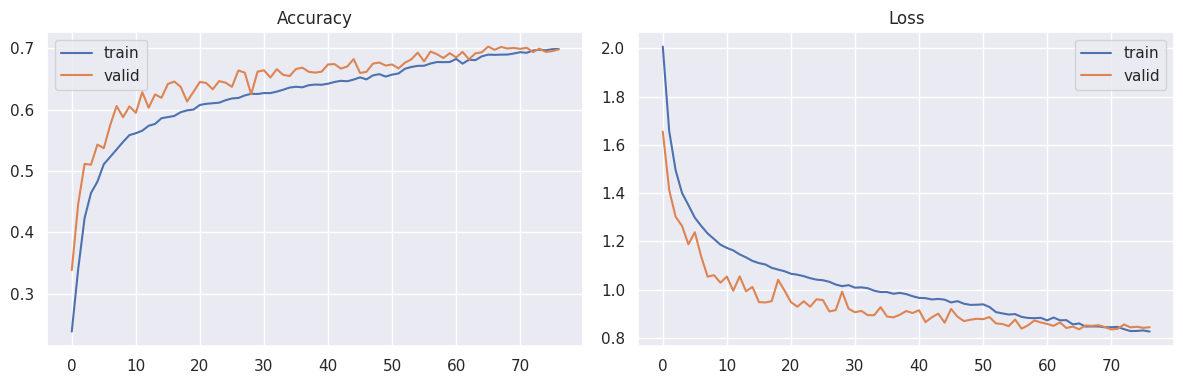

In [42]:
sns.set()
fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(history.epoch, history.history['accuracy'], label='train')
axes[0].plot(history.epoch, history.history['val_accuracy'], label='valid')
axes[0].set_title('Accuracy')
axes[0].legend()
axes[1].plot(history.epoch, history.history['loss'], label='train')
axes[1].plot(history.epoch, history.history['val_loss'], label='valid')
axes[1].set_title('Loss')
axes[1].legend()

pyplot.tight_layout()
pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()


101/101 [==============================] - 1s 8ms/step
total wrong validation predictions: 960


              precision    recall  f1-score   support

           0       0.62      0.65      0.63       445
           1       0.79      0.50      0.61        46
           2       0.57      0.44      0.49       409
           3       0.88      0.90      0.89       801
           4       0.60      0.61      0.60       558
           5       0.81      0.80      0.81       384
           6       0.62      0.71      0.66       587

    accuracy                           0.70      3230
   macro avg       0.70      0.66      0.67      3230
weighted avg       0.70      0.70      0.70      3230



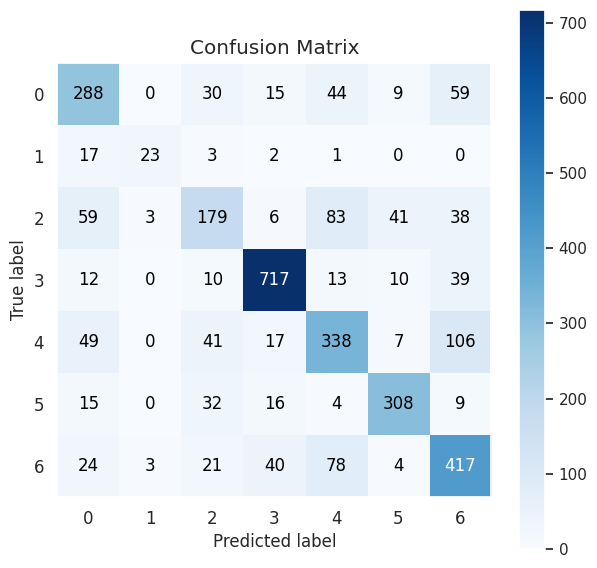

In [43]:
predict_x = model.predict(X_valid)
classes_x = np.argmax(predict_x,axis= 1)
skplt.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), classes_x,figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != classes_x)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), classes_x))

### The confusion matrix represents how well the model is performing on emotion with higher number of samples, while its performace is slightly worse on emotions with lower number of samples. On the other hand, it's challenging to accurately categorize certain emotions like Disgust vs. Angry and Fear vs. Neutral, a difficulty that even human observers encounter. This highlights the inherent variability in facial expressions.


### Confusion Matrix on Test data

113/113 [==============================] - 1s 10ms/step
total wrong test predictions: 1093


              precision    recall  f1-score   support

           0       0.62      0.69      0.66       495
           1       0.90      0.47      0.62        55
           2       0.57      0.42      0.49       512
           3       0.89      0.88      0.88       899
           4       0.61      0.58      0.60       608
           5       0.75      0.76      0.75       400
           6       0.61      0.75      0.67       620

    accuracy                           0.70      3589
   macro avg       0.71      0.65      0.67      3589
weighted avg       0.70      0.70      0.69      3589



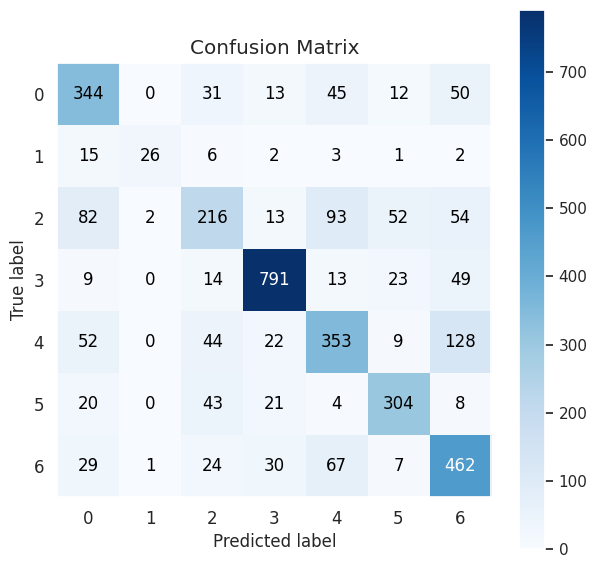

In [44]:
predict_x = loaded_model.predict(X_test)
classes_x = np.argmax(predict_x,axis= 1)
skplt.metrics.plot_confusion_matrix(np.argmax(y_test, axis=1), classes_x,figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong test predictions: {np.sum(np.argmax(y_test, axis=1) != classes_x)}\n\n')
print(classification_report(np.argmax(y_test, axis=1), classes_x))

113/113 [==============================] - 1s 8ms/step


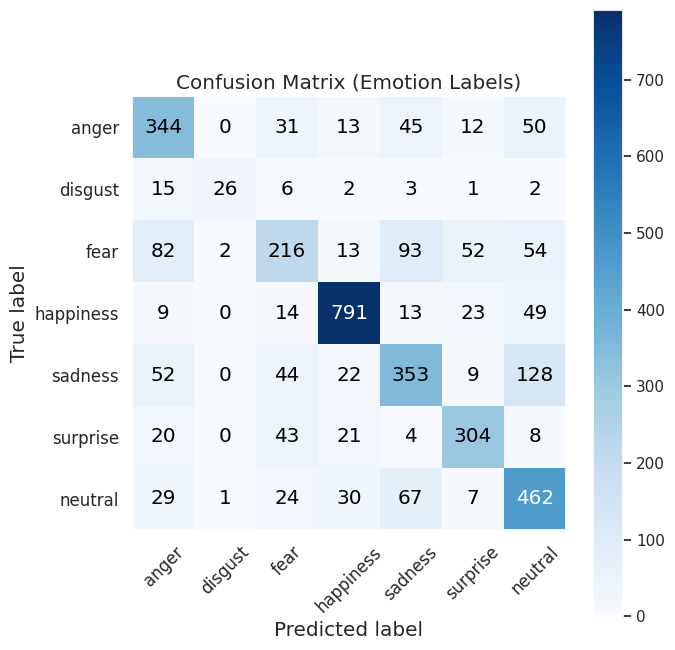

In [45]:
import scikitplot as skplt
import numpy as np
import matplotlib.pyplot as plt

# Define emotion labels
emotion_labels = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

# Make predictions
predict_x = model.predict(X_test)
classes_x = np.argmax(predict_x, axis=1)

# Plot confusion matrix
skplt.metrics.plot_confusion_matrix(np.argmax(y_test, axis=1), classes_x, figsize=(7, 7),
                                    title="Confusion Matrix (Emotion Labels)",
                                    text_fontsize='large', cmap='Blues')

# Replace x and y tick labels with emotion names
tick_marks = np.arange(len(emotion_labels))
plt.xticks(tick_marks, list(emotion_labels.values()), rotation=45, fontsize=12)
plt.yticks(tick_marks, list(emotion_labels.values()), fontsize=12)

plt.tight_layout()
plt.show()


In [46]:
from sklearn.metrics import confusion_matrix

y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, classes_x)

correct_pred_per_class = np.diag(cm)
incorrect_pred_per_class = np.sum(cm, axis=1) - np.diag(cm)

print("Correct predictions per class:", correct_pred_per_class)
print("Incorrect predictions per class:", incorrect_pred_per_class)


Correct predictions per class: [344  26 216 791 353 304 462]
Incorrect predictions per class: [151  29 296 108 255  96 158]


In [47]:
np.sum(incorrect_pred_per_class) +np.sum(correct_pred_per_class)

3589

In [48]:
np.sum(incorrect_pred_per_class)

1093

In [49]:
np.sum(correct_pred_per_class) / 3589

0.6954583449428811

In [50]:
np.array(correct_pred_per_class) / (np.array(correct_pred_per_class) + np.array(incorrect_pred_per_class))

array([0.69494949, 0.47272727, 0.421875  , 0.87986652, 0.58059211,
       0.76      , 0.74516129])

In [51]:
mapper = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "suprise",
    6: "neutral"
}



### We see random samples from emotion Disgust classified as emotion Angry/Neutral, as well as emotion Fear misclassified as Angry/Sad etc

1/1 [==============================] - 0s 21ms/step


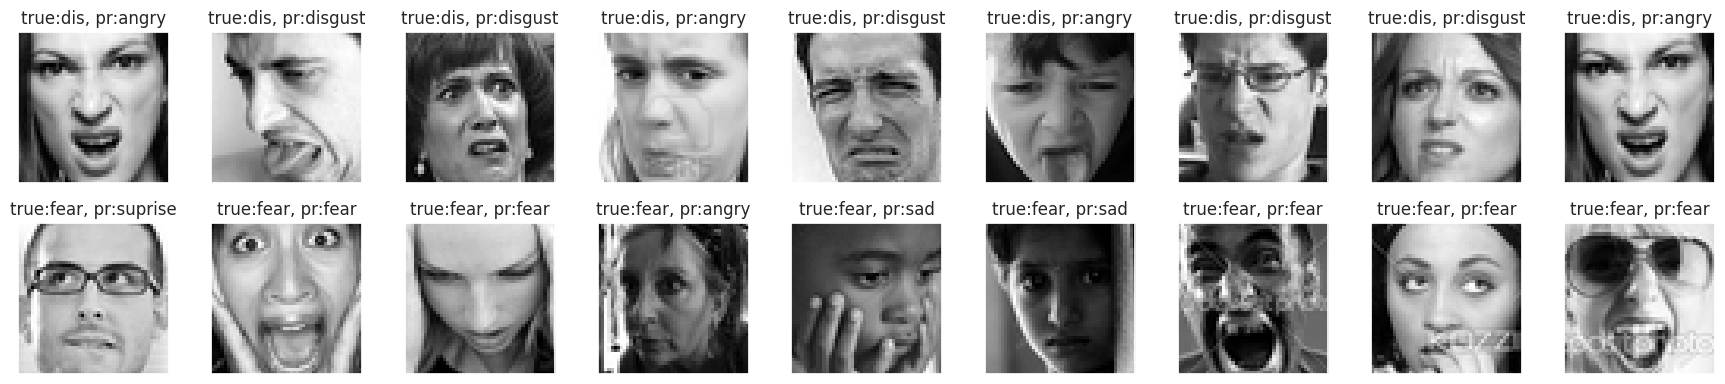

In [52]:
np.random.seed(2)


random_dis_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_fear_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)




fig = pyplot.figure(1, (18, 4))

for i, ( disidx, fearidx ) in enumerate(zip(random_dis_imgs, random_fear_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[disidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:dis, pr:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")



        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[fearidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:fear, pr:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")



        pyplot.tight_layout()





### We see random samples from emotion Sad classified as emotion Angry/Neutral, as well as emotion Neutral classified as Angry/Sad.

1/1 [==============================] - 0s 23ms/step


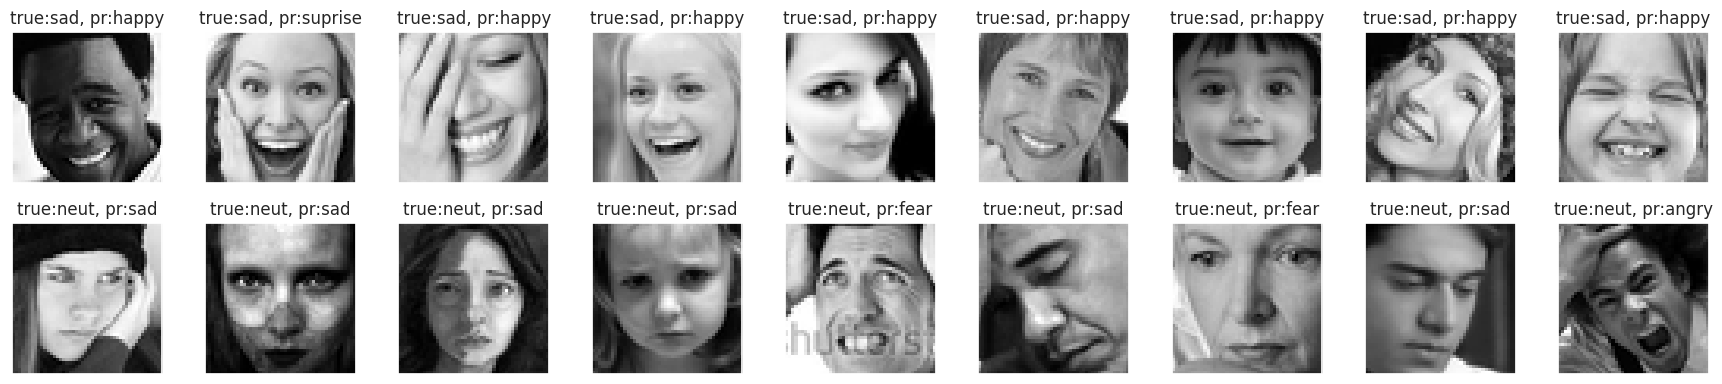

In [53]:
np.random.seed(2)


random_sad_imgs = np.random.choice(np.where(y_valid[:, 3]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 4]==1)[0], size=9)




fig = pyplot.figure(1, (18, 4))

for i, ( sadidx, neuidx ) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pr:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")



        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:neut, pr:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")



        pyplot.tight_layout()







1/1 [==============================] - 0s 20ms/step


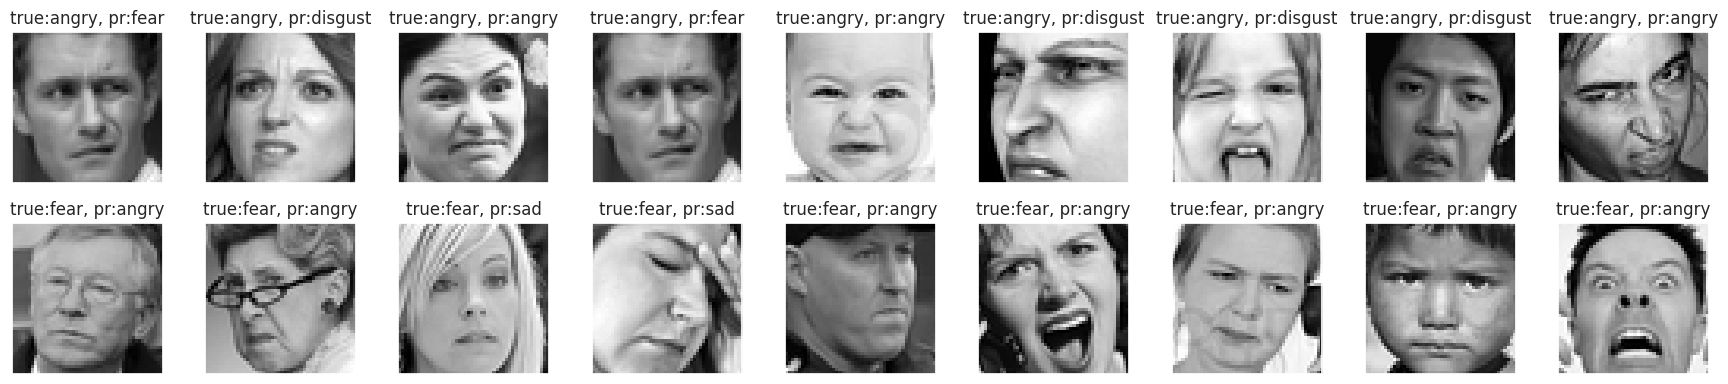

In [54]:
np.random.seed(2)

random_angry_imgs = np.random.choice(np.where(y_valid[:, 0]==1)[0], size=9)
random_fear_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
# random_happy_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)


fig = pyplot.figure(1, (18, 4))

for i, (fearidx , angryidx ) in enumerate(zip(random_angry_imgs,random_fear_imgs )):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[angryidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:angry, pr:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")



        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[fearidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:fear, pr:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1))[0])]}")



        pyplot.tight_layout()




